This notebook present some elements of the lowering of the family quotient trheshold that happened in 2012/2013

1- [Exemple pour deux enfants](#Exemple-for-a-couple-with-two-children)


2-[For any child number](#For-any-child-number)

In [46]:
%%capture #prevent output from printing
!pip install openfisca-france
!pip install matplotlib
!pip install mpld3
!pip install pandas==0.20.2 #A bug in pip prevent from importing further version

UsageError: unrecognized arguments: output from printing


In [1]:
%matplotlib inline
from __future__ import division

In [2]:
import matplotlib.pyplot as plt, mpld3
from matplotlib.ticker import FuncFormatter
from mpld3 import plugins
import pandas as pd
import numpy as np


In [3]:
!pip install pandas

In [4]:
!pip show openfisca_france

Name: OpenFisca-France
Version: 19.0.1
Summary: French tax and benefit system for OpenFisca
Home-page: https://github.com/openfisca/openfisca-france
Author: OpenFisca Team
Author-email: contact@openfisca.fr
License: http://www.fsf.org/licensing/licenses/agpl-3.0.html
Location: /Users/adrienpacifico/.local/share/virtualenvs/lowering_of_qf_to_trash/lib/python2.7/site-packages
Requires: numpy, OpenFisca-Core, requests, PyYAML


In [5]:
#Specific usage imports
from openfisca_core import periods, rates
import openfisca_france

In [6]:
import openfisca_france as openfisca_france_2

In [7]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()
tax_benefit_system_2 = openfisca_france_2.FranceTaxBenefitSystem()

In [8]:
ax_variable_max = 280000
count = 1000

year_lag_max = 10
def make_scenario(couple = False,nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count, age = 12):
    
    if count is None: count =  (ax_variable_max - ax_variable_min)/10 #Fais une simulation par tranche de 10 euros brut
    
    enfant = [dict(age = age)]
    enfants = enfant * nombre_enfants
    
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            [dict(count = count, 
                  min = ax_variable_min,
                  max = ax_variable_max,
                  name = axes_variable,
                  period = year-fill_lag) for fill_lag in range(year_lag_max)]
            ],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = u"Marié",
            ) if couple else dict(
            age = 40,
            ppe_du_sa = 6020, statut_marital = u"Célibataire"
            ),
        parent2 = dict(age = 40,ppe_du_sa = 6020,statut_marital = 1) if couple else None,
        enfants = enfants,
        menage = dict(
            loyer = 12000,
            statut_occupation_logement = 4,
            depcom = 13012,
            ),
        foyer_fiscal = dict(
            f7ea = nombre_enfants * ((age<15) * age>=11), #Nombre enfants à charge poursuivants leurs études : collège
            f7ec = nombre_enfants * ((age<19) * age>=15), #Nombre enfants à charge poursuivants leurs études : lycée
            f7ef = nombre_enfants * ((age<26) * age>=19), #Nombre enfants à charge poursuivants leurs études : Enseignement supérieur
            caseT = True # Warning ! TODO: mieux gérer, à priori pose pas de problème si True avec un couple marié...
            ),
        )
    return scenario


## Schedule of marginal income tax rate

In [9]:
empty_simulation = tax_benefit_system.new_scenario().new_simulation()
df = pd.DataFrame(index = range(6), columns= pd.MultiIndex.from_product([range(2011,2015), ["Rate", "Threshold"]]))
for year in range(2011, 2015):
    parameters = empty_simulation.parameters_at(periods.period(year))
    df.loc[:,(year,"Rate")] = pd.Series(parameters.impot_revenu.bareme.rates)
    df.loc[:,(year,"Threshold")] = pd.Series(parameters.impot_revenu.bareme.thresholds)
    pd.options.display.float_format = '{:20,.10g}'.format
    #df[year]["Rates"] = parameters.impot_revenu.bareme.rates


In [10]:
#print df.replace(np.nan, "").to_latex()
df.replace(np.nan, "")

2011                                      2012  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                0.055                5,963                0.055   
2                 0.14               11,896                 0.14   
3                  0.3               26,420                  0.3   
4                 0.41               70,830                 0.41   
5                                                           0.45   

                                       2013                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                5,963                0.055                6,011   
2               11,896                 0.14               11,991   
3               26,420                  0.3               26,631   
4               70,830                 0.41               71,397   
5              150,000                 0.45              151,200   

                  2014                       
                  Rate            Threshold  
0                    0                    0  
1                 0.14                9,690  
2                  0.3               26,764  
3                 0.41               71,754  
4                 0.45              151,956  
5

The above table present the __schedule__ of marginal income tax rate. 

Apart from:
* the anecdotical suppression of the 5.5% tax bracket (which concearned nearly no one due to the decote mechanism)
* and the introduction of a 45% tax bracket which increase the marginal tax rate of 3% for household over 151000 euros (thus 300 000 for a joint couple) which concerns last percentile (TODO: Check),

we see that the tax schedule is remarquably stable over the 2011, 2015 period.

## Joint taxation in France

Joint taxation in France consist of:
1. Pooling the income of all tax-household members, then divide it by the number of fiscal shares
2. Dividing that income by the number of fiscal shares (which depends of family composition)
3. Applying that income to the __tax schedule__
4. Multiplying the result by the number of fiscal shares  

Formally:  
<h1><center>$T(\frac{\sum{y_i}}{\text{fiscal shares}}) \times \text{fiscal shares} $  </center></h1>
Where $T()$ it the piecewise linear tax function and $y_i$ income of individual i.

The system of dividing the fiscal shares before applying the tax schedule aims to attain an equal sacrifice principle (by following some sort of equivalent scale principle).

For that reason we call the ratio $ \frac{\sum{y_i}}{\text{fiscal shares}}$, the equivalized income.

The mechanism taking into account the equivalized income to compute the tax is called the *quotient familial* (QF) 

## Number of fiscal shares based on family composition.

In [11]:
simulation_dict_couple = dict()
for nb_enf in range(0,6):
    simulation_dict_couple[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_couple[nb_enf][year] = make_scenario(couple = True,nombre_enfants=nb_enf,year = year, count= 1).new_simulation()
simulation_dict_single = dict()
for nb_enf in range(0,6):
    simulation_dict_single[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_single[nb_enf][year] = make_scenario(couple = False,nombre_enfants=nb_enf,year = year, count=1).new_simulation()

In [12]:
df = pd.DataFrame(index = range(6), columns=  ["Couple", "Single"])
for nb_enf in range(0, 6):
    simulation_dict_couple[2][2015].calculate("nbptr", period = "2015")

    df.loc[nb_enf,"Couple"] = simulation_dict_couple[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    df.loc[nb_enf,"Single"] = simulation_dict_single[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    pd.options.display.float_format = '{:20,.10g}'.format
    #df[year]["Rates"] = parameters.impot_revenu.bareme.rates
    df.index.name = "Children"

In [13]:
df

,Couple,Single
Children,,
0,2,1
1,2.5,2
2,3,2.5
3,4,3.5
4,5,4.5
5,6,5.5


The above table show the number of fiscal share for either a couple under civil union, or a single based on the number of children.

There exists other situations not reported in the table (children with disability, dependent relatives, etc).  
For cohabiting couples (not filling jointly) we have to substract 0.5 fiscal share.

### Exemple for a couple with two children

In [14]:
nb_enf = 2

In [15]:
simulation_dict_no_child = dict()
for year in range(2009,2017): 
    simulation_dict_no_child[year] = make_scenario(couple = True,nombre_enfants=0,year = year, ax_variable_min=1000).new_simulation()

In [16]:
simulation_dict = dict()
for year in range(2009,2017): 
    simulation_dict[year] = make_scenario(couple = True,nombre_enfants=nb_enf,year = year, ax_variable_min=1000).new_simulation()

In [17]:
print simulation_dict[2014].calculate('irpp', period = 2014)[700] - simulation_dict[2014].calculate('reductions', period = 2014)[700] 
print simulation_dict[2014].calculate('rng', period = 2014)[700]
print simulation_dict[2014].calculate_add('salaire_imposable', period = 2014)[700*4]

-34799.1
158241.0
170398.0


(10000, 90000)

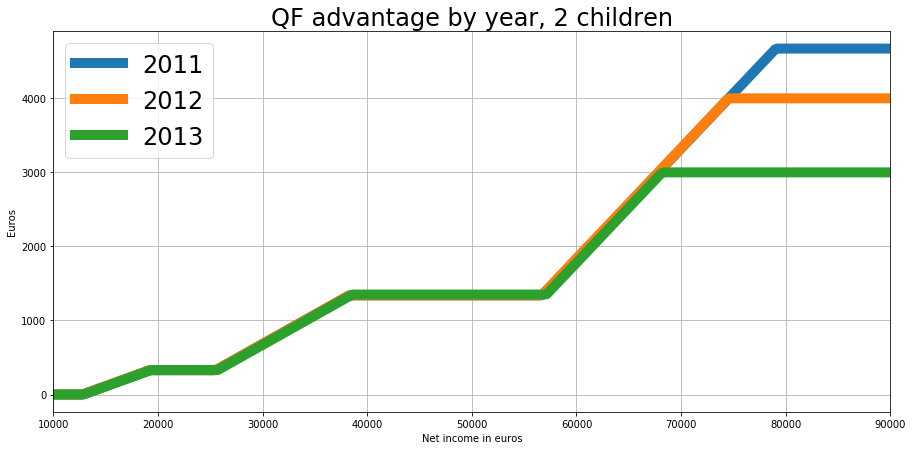

In [18]:
fig = plt.figure(figsize=(15,7))
for year in [2011,2012,2013]:
    plt.plot(simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf],
             simulation_dict[year].calculate("avantage_qf", period = year), label = year, linewidth = 10)
plt.title('QF advantage by year, {} children'.format(nb_enf), fontsize = 24)
plt.xlabel('Net income in euros')
plt.ylabel('Euros')
plt.grid(True)
plt.legend(fontsize = 24)
plt.xlim((10000,90000))

We see the fiscal gain from the QF has some plateau, e.g. between 39000 and 57000 euros, this correspond to places where the additional fiscal shares from children doesn't put the household on a lower tax bracket.  

In [19]:
smooth = 3

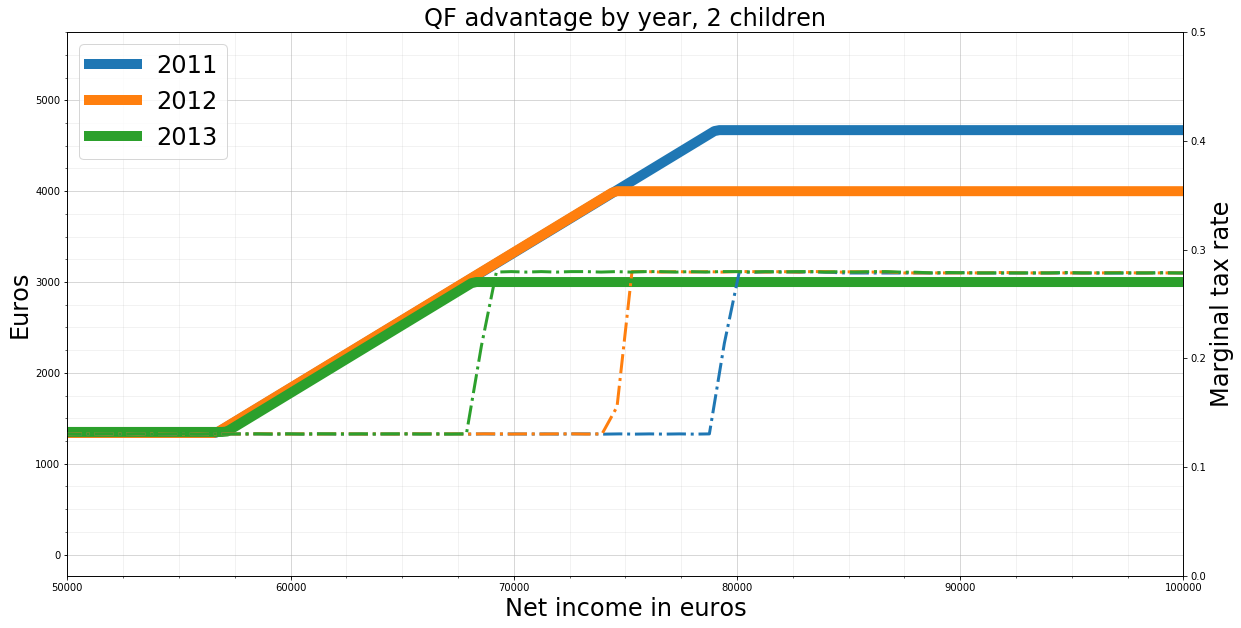

In [20]:
import numpy as np                                                               
import matplotlib.pyplot as plt                                                                                                                                 

fig = plt.figure(figsize=(20,10)) ; ax = fig.add_subplot(1,1,1)                                                      

ax2 = ax.twinx()
for year in [2011,2012,2013]:
    ax.plot(simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf],
             simulation_dict[year].calculate("avantage_qf", period = year), label = year, linewidth = 10)
    ax2.plot(simulation_dict[year].calculate_add("salaire_net",year)[::2+nb_enf][::smooth][1:],
      rates.marginal_rate(simulation_dict[year].calculate_add("revenu_disponible",year)[::smooth],
        simulation_dict[year].calculate_add("salaire_net",year)[::2+nb_enf][::smooth] ), 
     label = year, linewidth = 3, linestyle = '-.')
    
    

ax.set_title('QF advantage by year, {} children'.format(nb_enf), fontsize = 24)
ax.set_xlabel('Net income in euros', fontsize = 24)
ax.set_ylabel('Euros', fontsize = 24)
ax2.set_ylabel('Marginal tax rate', fontsize = 24)
ax.legend(fontsize = 24)

major_ticks = np.arange(0, 140000, 10000)                                              
minor_ticks = np.arange(0, 140000, 2500)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
ax.set_yticks(np.arange(0, 6000, 1000))                                                       
ax.set_yticks(np.arange(0, 6000, 250), minor=True)                                           
ax.grid(which='both')                                                                                         
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)                                                

ax2.set_ylim(0,0.5)


plt.xlim((50000,100000))

plt.show()

We see the the impact of lowering the QF on marginal tax rate, and fiscal gain from QF.

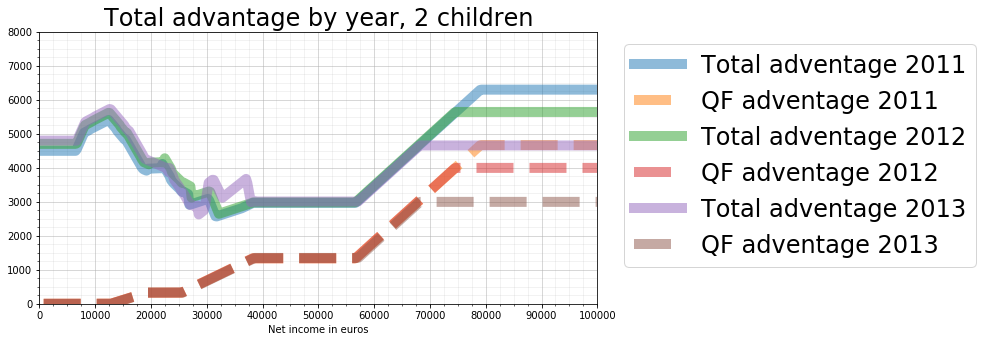

In [21]:
import numpy as np                                                               
import matplotlib.pyplot as plt                                                                                                                                 

fig = plt.figure(figsize=(10,5)) ; ax = fig.add_subplot(1,1,1)                                                      


for year in [2011,2012,2013]:
    avantage_enfant = simulation_dict[year].calculate("revenu_disponible", period = year) - simulation_dict_no_child[year].calculate("revenu_disponible", period = year)
    ax.plot(simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf],
             avantage_enfant, label = "Total adventage {}".format(year), linewidth = 10, alpha = 0.5)

    ax.plot(simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf],
             simulation_dict[year].calculate("avantage_qf", period = year), label = "QF adventage {}".format(year), linewidth = 10, linestyle = "--", alpha = 0.5)

#plugins.connect(fig, plugins.MousePosition(fontsize=24, fmt='.5g'))
ax.set_title('Total advantage by year, {} children'.format(nb_enf), fontsize = 24)
ax.set_xlabel('Net income in euros')
ax.set_label('Euros')
ax.legend(fontsize = 24, loc=1, bbox_to_anchor=(1.7,1))

# major ticks every 20, minor ticks every 5                                      
major_ticks = np.arange(0, 140000, 10000)                                              
minor_ticks = np.arange(0, 140000, 2500)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
ax.set_yticks(np.arange(0, 100000, 1000))                                                       
ax.set_yticks(np.arange(0, 100000, 250), minor=True)                                           

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)                                                




plt.xlim((0,100000)) ; plt.ylim((0,8000)) 

plt.show()

We see that for over 40k euros households, the only varying factor for gains related to children is the QF. Other tax breaks/benefits such as family allowances or ecpess are lump sum.

(0, 150000)

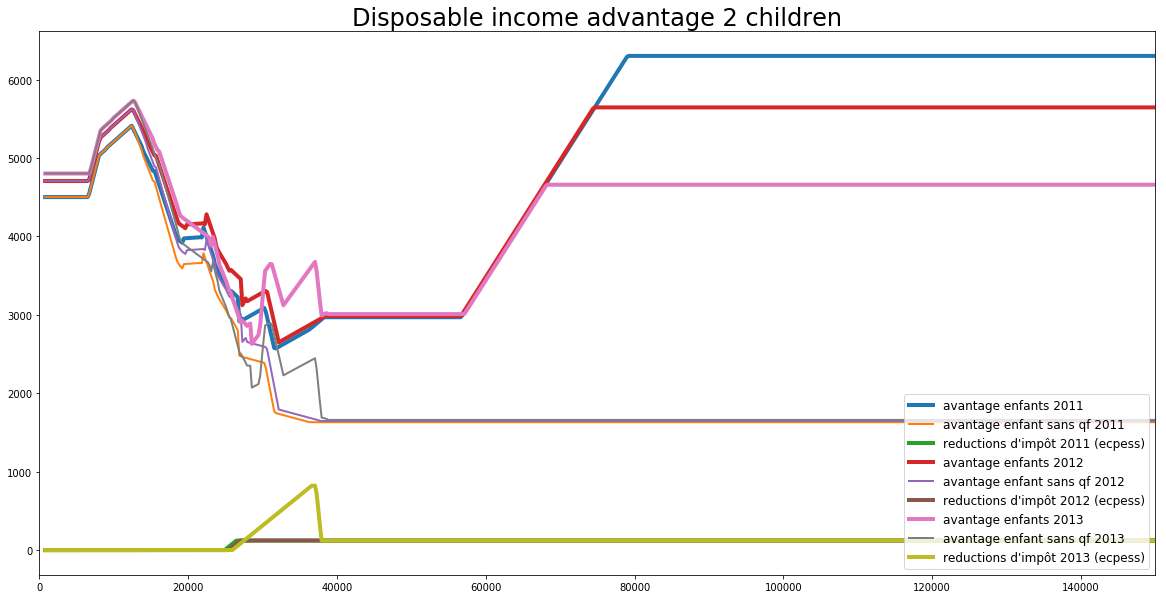

In [22]:
# CHild advantage by year




fig = plt.figure(figsize=(20,10))
for year in [2011,2012,2013]:
    salaire_net =  simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf]
    avantage_enfant =  simulation_dict[year].calculate("revenu_disponible", period = year) - simulation_dict_no_child[year].calculate("revenu_disponible", period = year)
    plt.plot(salaire_net,avantage_enfant,
             label = 'avantage enfants {}'.format(year), linewidth = 4)
    
    avantage_qf =  simulation_dict[year].calculate("avantage_qf", period = year)
    
    plt.plot(salaire_net,avantage_enfant - avantage_qf,
             label = "avantage enfant sans qf {}".format(year), linewidth = 2)
    
    
    reductions_impot =  simulation_dict[year].calculate("reductions", period = year)
    plt.plot(salaire_net,reductions_impot,
             label = u"reductions d'impôt {} (ecpess)".format(year), linewidth = 4) # Reductions due aux enfants à charge poursuivants leurs études (ecpess)
    


    af = simulation_dict[year].calculate_add("af", period = year)

plt.title('Disposable income advantage {} children'.format(nb_enf), fontsize = 24)
plt.legend(fontsize = 12, loc = 4)
plt.xlim(0, 150000)
#plt.ylim(0,8000)

We see that over 40 000 euros there is only three benefits related to children :
* The family allowance (Allocations familliales)
* The ecpess for children pursuing the studies
* The QF mechanism

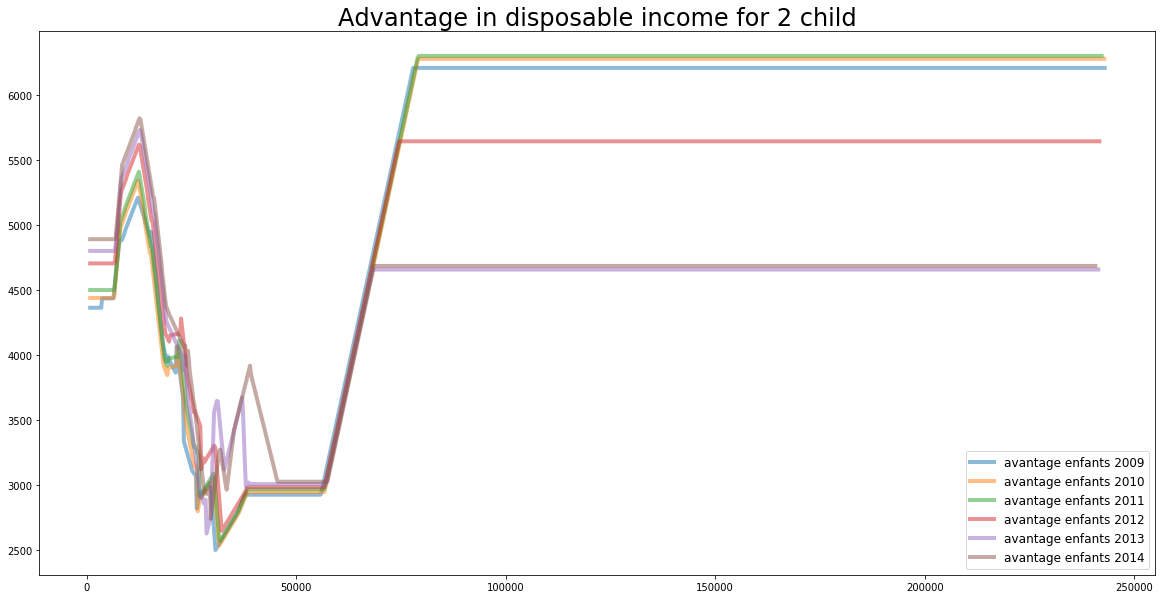

In [23]:
# CHild advantage by year




fig = plt.figure(figsize=(20,10))
for year in range(2009,2015):
    salaire_net =  simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf]
    avantage_enfant =  simulation_dict[year].calculate("revenu_disponible", period = year) - simulation_dict_no_child[year].calculate("revenu_disponible", period = year)
    plt.plot(salaire_net,avantage_enfant,
             label = 'avantage enfants {}'.format(year), linewidth = 4, alpha = 0.5)

plt.title('Advantage in disposable income for {} child'.format(nb_enf), fontsize = 24)
plt.legend(fontsize = 12, loc = 4)
#plt.ylim(0,8000)






We see on that graph that the fiscal gain from children in the upper part of the distribution from 2009 to 2014 has changed solely due to the threshold of the QF (no other instrument has been implied).

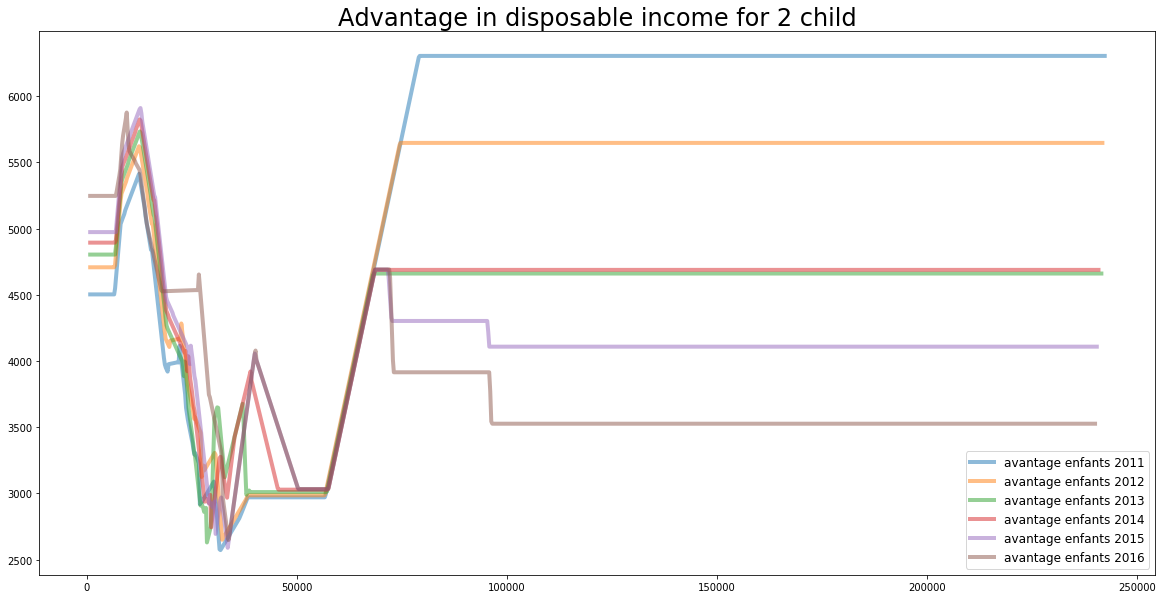

In [24]:
# CHild advantage by year




fig = plt.figure(figsize=(20,10))
for year in range(2011,2017):
    salaire_net =  simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf]
    avantage_enfant =  simulation_dict[year].calculate("revenu_disponible", period = year) - simulation_dict_no_child[year].calculate("revenu_disponible", period = year)
    plt.plot(salaire_net,avantage_enfant,
             label = 'avantage enfants {}'.format(year), linewidth = 4, alpha = 0.5)

plt.title('Advantage in disposable income for {} child'.format(nb_enf), fontsize = 24)
plt.legend(fontsize = 12, loc = 4)
#plt.ylim(0,8000)






In 2015 the reform stated as the modulation of family allowances kicks in, and reduces the gain from children for rich familly with two children or more.

In [25]:
%matplotlib inline

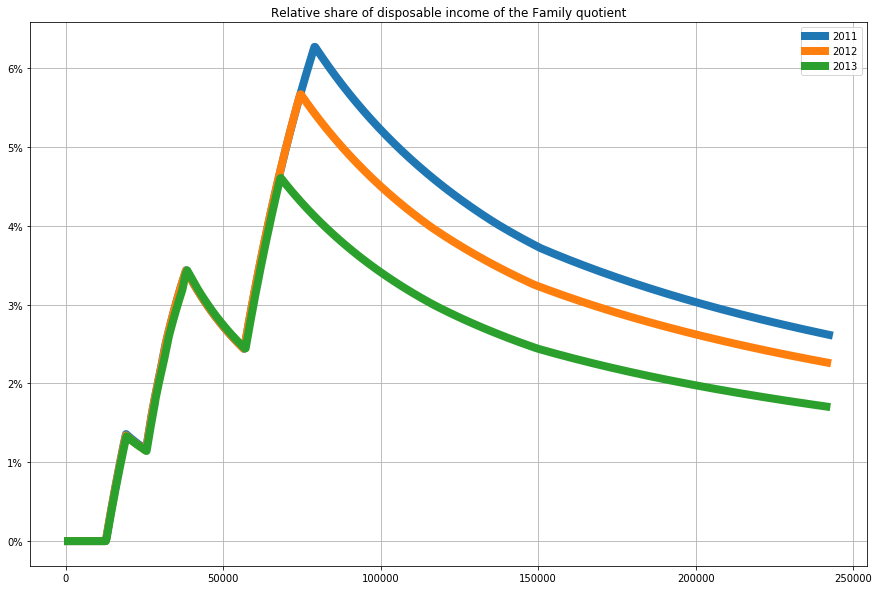

In [26]:
fig = plt.figure(figsize=(15,10))
for year in [2011,2012,2013]:
    
    relative_qf_gain = (simulation_dict[year].calculate("avantage_qf", period = year)/
             simulation_dict[year].calculate_add("revenu_disponible", period = year))

    plt.plot(simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf],
            relative_qf_gain,
            label = "{}".format(year),  linewidth=8)

plt.title("Relative share of disposable income of the Family quotient") 
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend()
plt.grid()

The figure above shows that the QF mechanism is important for the household budget, it counts up to 6.3% of disposable income for a household of two children in 2011. The reform shift that number down to 4.6%.

Text(0.5,1,u'Share of QF in disposable income')

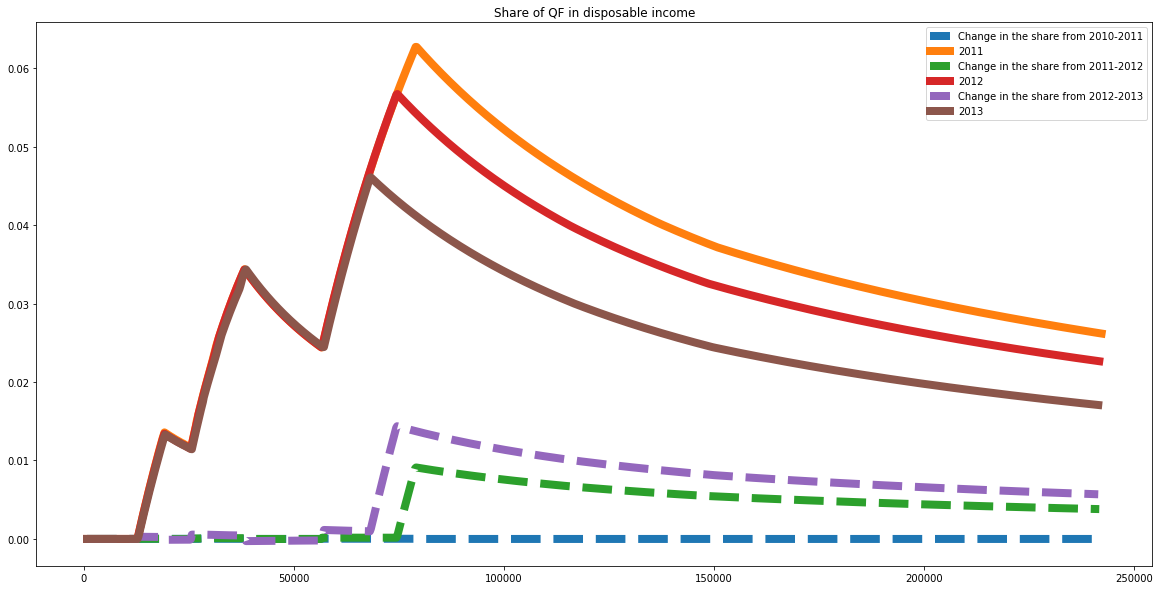

In [27]:

fig, ax2 = plt.subplots(figsize=(20,10))
for year in [2011,2012,2013]:
    salaire_net = simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf]
    avantage_enfant =  simulation_dict[year].calculate("revenu_disponible", period = year) - simulation_dict_no_child[year].calculate("revenu_disponible", period = year)
   
        
    relative_qf_gain_1 = (simulation_dict[year].calculate("avantage_qf", period = year)/
             simulation_dict[year].calculate_add("revenu_disponible", period = year))
    
    relative_qf_gain_2 = (simulation_dict[year-1].calculate("avantage_qf", period = year-1)/
             simulation_dict[year].calculate_add("revenu_disponible", period = year))
    ax2.plot(salaire_net,
             (relative_qf_gain_2 - relative_qf_gain_1),
                label = "Change in the share from {}-{}".format(year-1,year),  linewidth=8, linestyle = '--')
    relative_qf_gain = (simulation_dict[year].calculate("avantage_qf", period = year)/
             simulation_dict[year].calculate_add("revenu_disponible", period = year))

    ax2.plot(simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf],
            relative_qf_gain,
            label = "{}".format(year),  linewidth=8)
plt.legend()
plt.title("Share of QF in disposable income")

2011
2012
2013


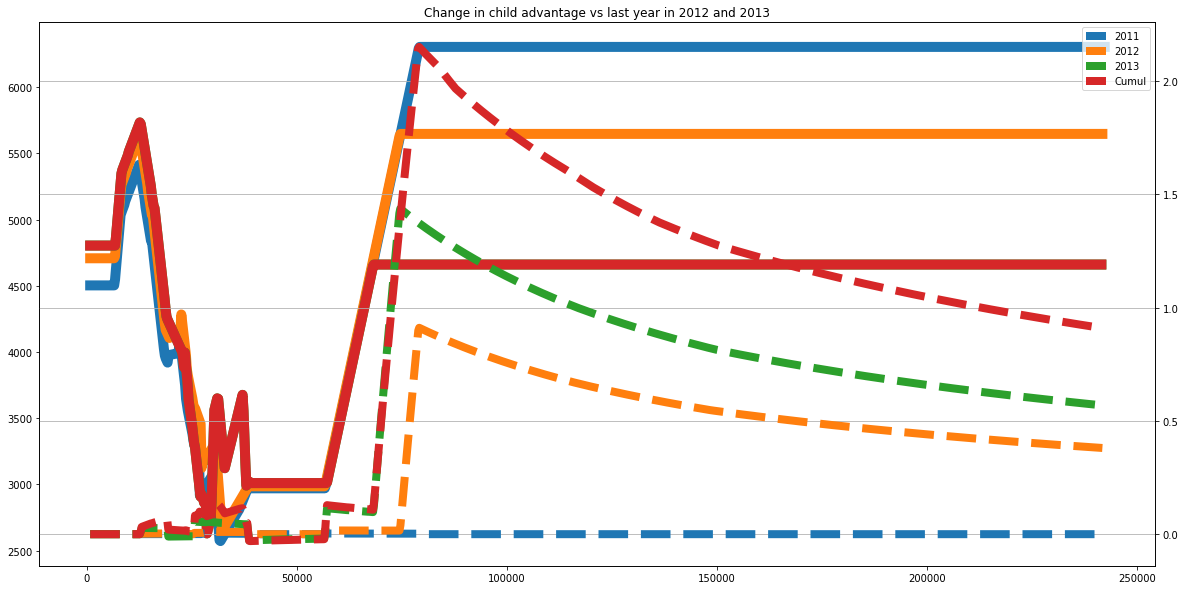

In [28]:

fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()

for year in [2011,2012,2013]:
    print year
    salaire_net = simulation_dict[year].calculate_add("salaire_net", period = year)[::2+nb_enf]
    avantage_enfant =  simulation_dict[year].calculate("revenu_disponible", period = year) - simulation_dict_no_child[year].calculate("revenu_disponible", period = year)
    ax1.plot(salaire_net,avantage_enfant,
             label = year, linewidth = 10)    
        
    relative_qf_gain_1 = (simulation_dict[year].calculate("avantage_qf", period = year)/
             simulation_dict[year].calculate_add("revenu_disponible", period = year))
    
    relative_qf_gain_2 = (simulation_dict[year-1].calculate("avantage_qf", period = year-1)/
             simulation_dict[year].calculate_add("revenu_disponible", period = year))
    ax2.plot(salaire_net,
             (relative_qf_gain_2 - relative_qf_gain_1)*100
             
             , label = year,  linewidth=8, linestyle = '--')
    
    
avantage_enfant =  simulation_dict[year].calculate("revenu_disponible", period = year) - simulation_dict_no_child[year].calculate("revenu_disponible", period = 2013)
ax1.plot(salaire_net,avantage_enfant,
         label = "Cumul", linewidth = 10)    

relative_qf_gain_1 = (simulation_dict[2013].calculate("avantage_qf", period = 2013)/
         simulation_dict[2013].calculate_add("revenu_disponible", period = 2013))

relative_qf_gain_2 = (simulation_dict[2011].calculate("avantage_qf", period = 2011)/
         simulation_dict[2011].calculate_add("revenu_disponible", period = 2011))
ax2.plot(salaire_net,
         (relative_qf_gain_2 - relative_qf_gain_1)*100

         , label = "Cumul",  linewidth=8, linestyle = '--')
plt.title('Change in child advantage vs last year in 2012 and 2013')
plt.legend()
plt.grid()



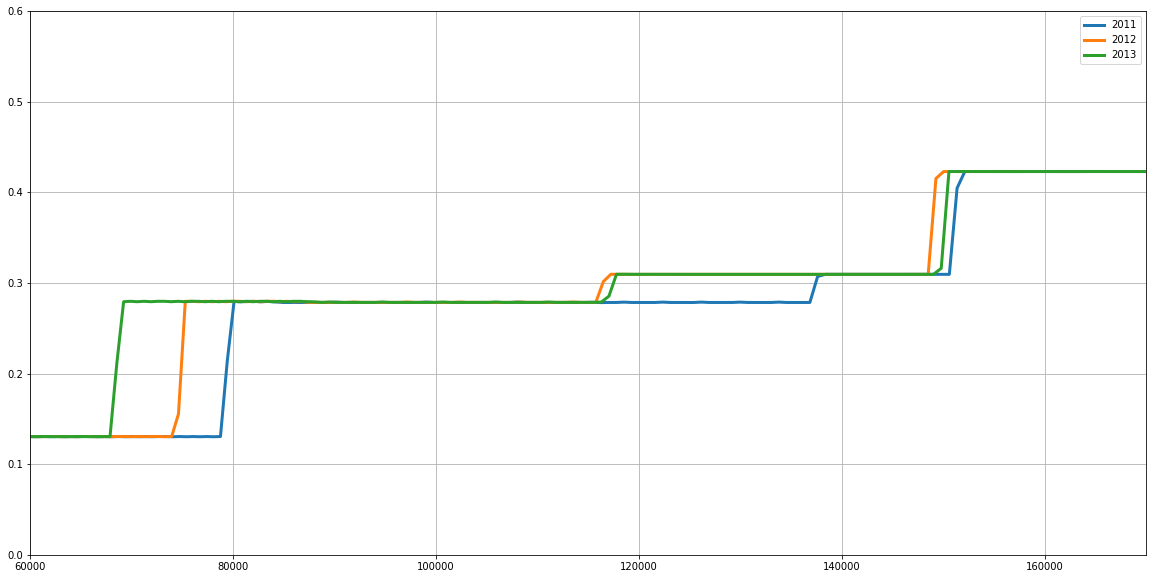

In [29]:
smooth = 3
fig = plt.figure(figsize=(20,10))

for year in [2011,2012,2013]: 
    plt.plot(simulation_dict[year].calculate_add("salaire_net",year)[::2+nb_enf][::smooth][1:],
             rates.marginal_rate(simulation_dict[year].calculate_add("revenu_disponible",year)[::smooth],
                simulation_dict[year].calculate_add("salaire_net",year)[::2+nb_enf][::smooth]), 
             
             label = year, linewidth = 3) ; plt.legend()


plugins.connect(fig, plugins.MousePosition(fontsize=24, fmt='.5g'))
plt.legend()
plt.ylim((0,0.6))
plt.xlim((60000,170000))
plt.grid()


# For any child number

In [30]:

simulation_dict = dict()
for nb_enf in range(0,20):
    simulation_dict[nb_enf] = dict()
    for year in range(2007,2016): 
        simulation_dict[nb_enf][year] = make_scenario(couple = True,nombre_enfants=nb_enf,year = year, ax_variable_min=10000).new_simulation()

### Avantage QF

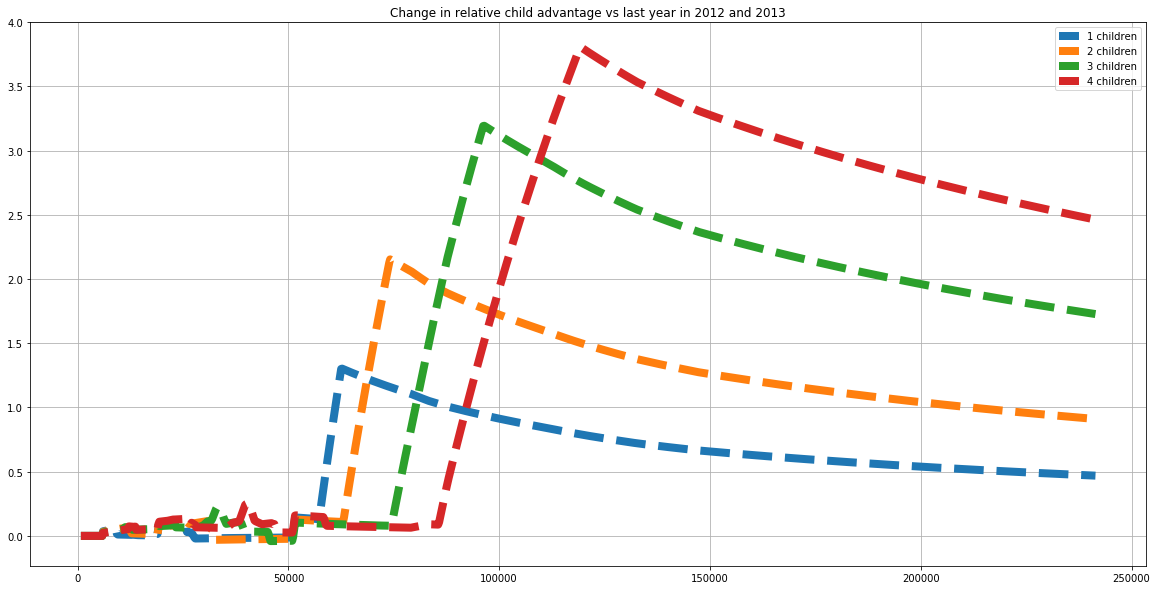

In [31]:

fig, ax1 = plt.subplots(figsize=(20,10))




for nb_enf in range(1,5):   

    relative_qf_gain_1 = (simulation_dict[nb_enf][2013].calculate("avantage_qf", period = 2013)/
             simulation_dict[nb_enf][2013].calculate_add("revenu_disponible", period = 2013))

    relative_qf_gain_2 = (simulation_dict[nb_enf][2011].calculate("avantage_qf", period = 2011)/
             simulation_dict[nb_enf][2011].calculate_add("revenu_disponible", period = 2011))
    ax1.plot(salaire_net,
             (relative_qf_gain_2 - relative_qf_gain_1)*100

             , label = "{} children".format(nb_enf),  linewidth=8, linestyle = '--')
plt.title('Change in relative child advantage vs last year in 2012 and 2013')
plt.legend()
plt.grid()



### Repérer quand on atteint le plafond du QF.

In [32]:
gain = simulation_dict[2][2011].calculate("avantage_qf", period = 2011) ; print gain.shape
print np.where(gain<gain[::-1])[0][-1]
simulation_dict[2][2011].calculate_add("salaire_net", period = year)[::2+2][np.where(gain<gain[::-1])[0][-1]]

(1000,)
330


0.0

In [33]:
simulation_dict[2][2011].calculate_add("salaire_net", period = 2011)[::2+2][330]

78895.711

In [34]:
df = pd.DataFrame()
for year in [2011,2013]:
    s = pd.Series()
    for nb_enf in range(1,7):
        gain = simulation_dict[nb_enf][year].calculate("avantage_qf", period = year)
        s = s.append(pd.Series(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf][np.where(gain<gain[-1])[0][-1]]))
    df[year] =s 
df.reset_index(inplace = True, drop = True);df.index.name = "Nb child" ; df.index = df.index+1 
df

,2011,2013
Nb child,,
1,"67,856.28125","62,519.625"
2,"78,895.71094","68,140.53125"
3,"101,426.3125","79,166.1875"
4,"123,756.0859","90,221.67188"
5,"145,188.6562","101,272.8594"
6,"159,477.0156","112,324.0391"


In [35]:
df_rbg = pd.DataFrame()
for year in [2011,2013]:
    s = pd.Series()
    for nb_enf in range(1,7):
        gain = simulation_dict[nb_enf][year].calculate("avantage_qf", period = year)
        s = s.append(pd.Series(simulation_dict[nb_enf][year].calculate_add("rbg", period = year)[::][np.where(gain<gain[-1])[0][-1]]))
    df_rbg[year] = s 
df_rbg.reset_index(inplace = True, drop = True);df_rbg.index.name = "Nb child" ;
df_rbg

,2011,2013
Nb child,,
0,"63,232.72656","58,291.22656"
1,"73,516.89844","63,530.33594"
2,"94,451.35938","73,806.72656"
3,"115,185.7656","84,103.25781"
4,"135,941.2188","94,368.66406"
5,"150,684.1875","104,633.1016"


In [36]:
import seaborn as sns

In [37]:
sns.set()

(0, 10000)

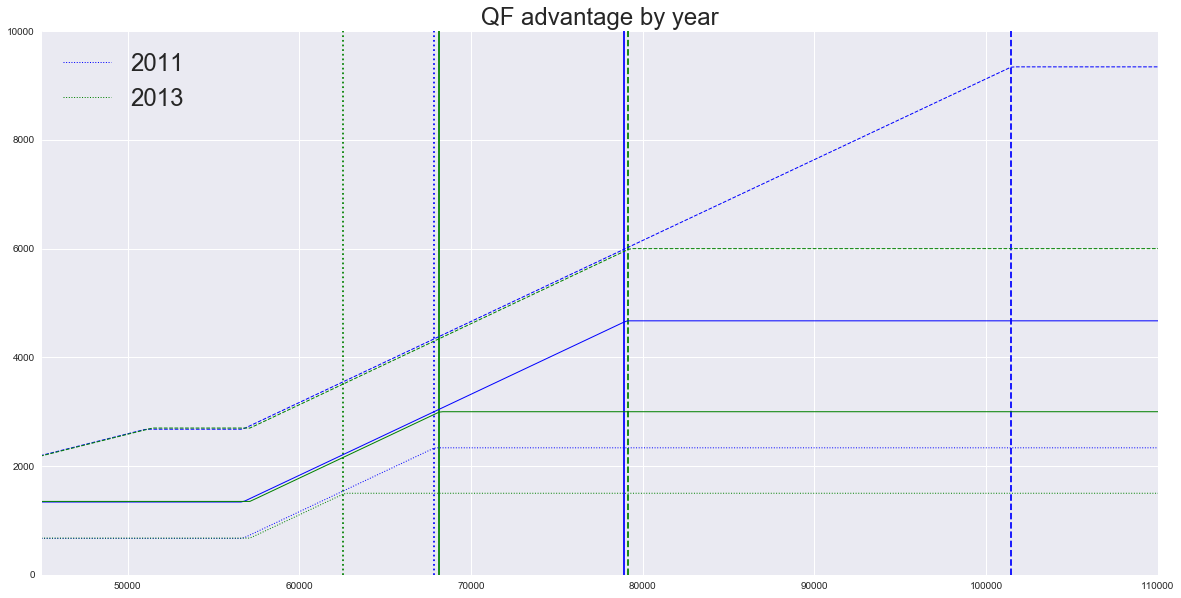

In [38]:
fig = plt.figure(figsize=(20,10))

year_color = {2011:'b', 2012:'r', 2013:'g'}
children_linestyle = {1:':', 2:'-', 3:'--'}
for nb_enf in range(1,4):
    for year in [2011,2013]:
        plt.plot(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf],
                 simulation_dict[nb_enf][year].calculate("avantage_qf", period = year), label = year, linewidth = 1, color = year_color[year], 
                linestyle = children_linestyle[nb_enf])
        legend  = plt.legend(fontsize = 24)

#plugins.connect(fig, plugins.MousePosition(fontsize=24, fmt='.5g'))
plt.title('QF advantage by year', fontsize = 24)

for child, val in df[2011].head(3).iteritems(): 
    plt.vlines(val, 0,40000, color = 'b', linestyle = children_linestyle[child])
for child, val in df[2013].head(3).iteritems(): 
    plt.vlines(val, 0,40000, color = 'g', linestyle = children_linestyle[child])
plt.xlim(45000,110000)
plt.ylim(0,10000)
#legend1 = pyplot.legend(plot_lines[0], ["algo1", "algo2", "algo3"], loc=1)

(0, 1)

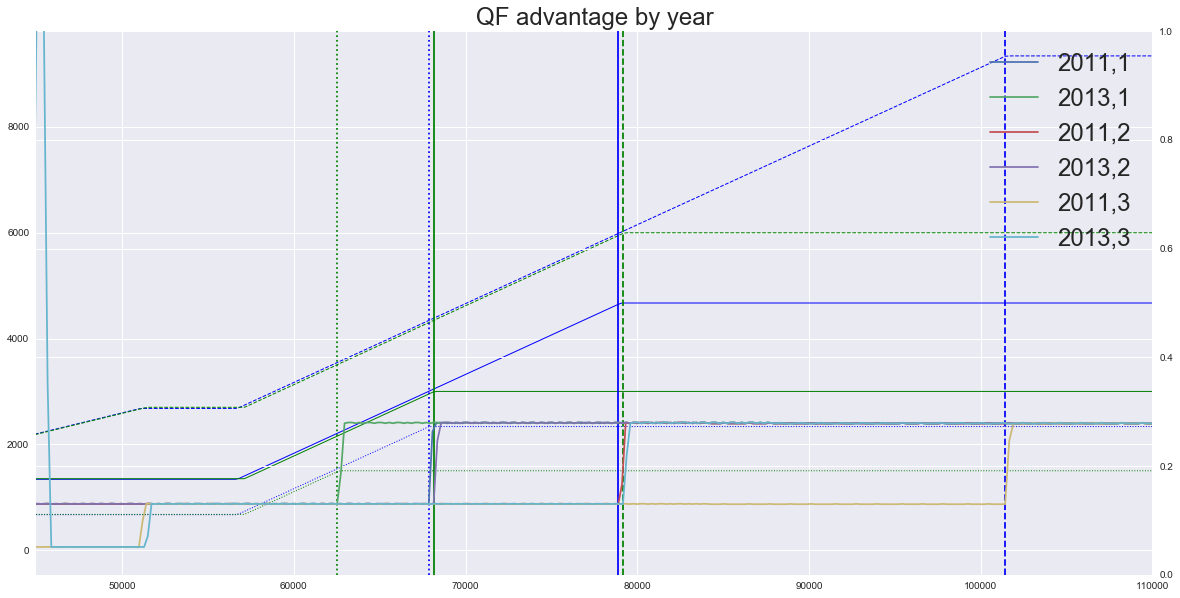

In [39]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)                                                      

ax2 = ax.twinx()

year_color = {2011:'b', 2012:'r', 2013:'g'}
children_linestyle = {1:':', 2:'-', 3:'--'}
for nb_enf in range(1,4):
    for year in [2011,2013]:
        ax.plot(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf],
                 simulation_dict[nb_enf][year].calculate("avantage_qf", period = year), label = year, linewidth = 1, color = year_color[year], 
                linestyle = children_linestyle[nb_enf])
        gain_enfant = (simulation_dict[nb_enf][year].calculate("revenu_disponible", period = year) - 
               simulation_dict_no_child[year].calculate("revenu_disponible", period = year))
        
        gain_rate =  (1-rates.marginal_rate(-simulation_dict[nb_enf][year].calculate("irpp", period = year)[1:],
                    simulation_dict[nb_enf][year].calculate_add("salaire_net",year)[2+nb_enf::2+nb_enf]))
        ax2.plot(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[(2+nb_enf)*2::2+nb_enf],gain_rate, 
                 label = "{},{}".format(year,nb_enf) )
        
        legend  = plt.legend(fontsize = 24)

#plugins.connect(fig, plugins.MousePosition(fontsize=24, fmt='.5g'))
plt.title('QF advantage by year', fontsize = 24)

for child, val in df[2011].head(3).iteritems(): 
    plt.vlines(val, 0,40000, color = 'b', linestyle = children_linestyle[child])
for child, val in df[2013].head(3).iteritems(): 
    plt.vlines(val, 0,40000, color = 'g', linestyle = children_linestyle[child])
plt.xlim(45000,110000)
plt.ylim(0,10000)
ax2.set_ylim((0,1))
#legend1 = pyplot.legend(plot_lines[0], ["algo1", "algo2", "algo3"], loc=1)

## Appendix

### Qf advantage up to ten children

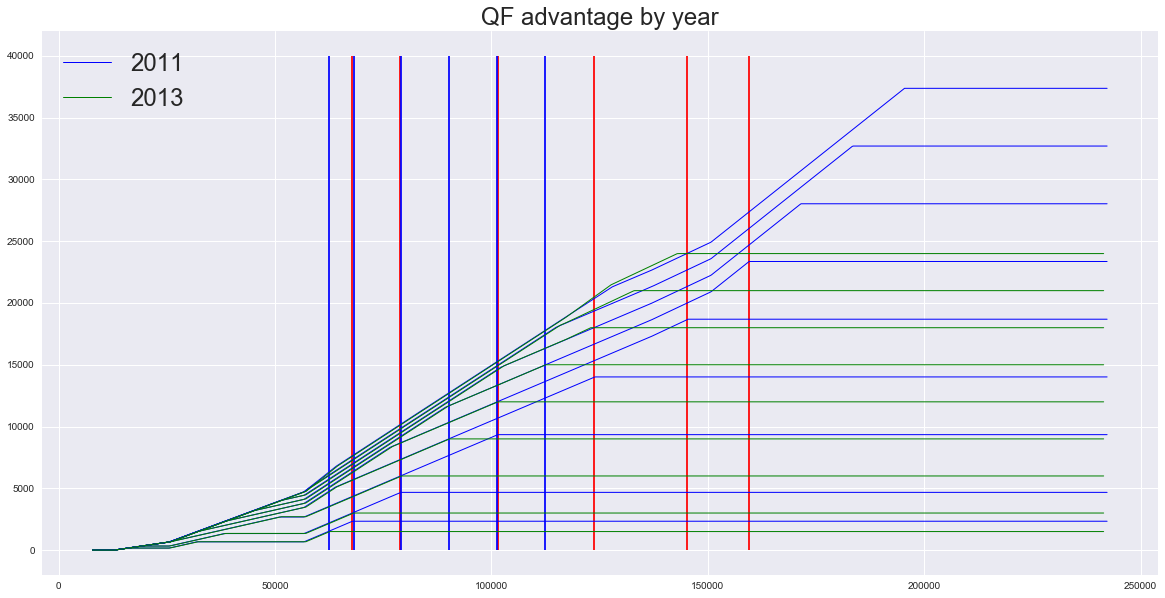

In [40]:
fig = plt.figure(figsize=(20,10))

year_color = {2011:'b', 2012:'r', 2013:'g'}
for nb_enf in range(1,10):
    for year in [2011,2013]:
        plt.plot(simulation_dict[nb_enf][year].calculate_add("salaire_net", period = year)[::2+nb_enf],
                 simulation_dict[nb_enf][year].calculate("avantage_qf", period = year), label = year, linewidth = 1, color = year_color[year])

#plugins.connect(fig, plugins.MousePosition(fontsize=24, fmt='.5g'))
plt.title('QF advantage by year', fontsize = 24)
plt.legend(fontsize = 24)
for val in df[2011]: 
    plt.vlines(val, 0,40000, color = 'r')
for val in df[2013]: 
    plt.vlines(val, 0,40000, color = 'b')
#mpld3.display()